# Universidad del Valle de Guatemala
## Facultad de Ingeniería
### Departamento de Computación

---

# Proyecto 2: Análisis Exploratorio
## Proyecto 2. Reto 04: Predicción de compradores recurrentes: cuestionar la línea base - Negocios

**Integrantes:**
- Diego Alexander Hernández Silvestre, 21270
- Linda Inés Jiménez Vides, 21169
- Mario Antonio Guerra Morales, 21008
- David Jonathan Aragon Vasquez, 21053

**Curso:** Data Science  
**Sección:** 10  
**Grupo** 4  

---

Guatemala, 30 de septiembre de 2024


##### 🫳 Para la descarga del dataset de este reto, es necesario la creación de una cuenta dentro de Alibaba Cloud. Para facilitar este proceso se proporcionan los elementos a descargar en estos enlaces:
- Data_Format1: https://drive.google.com/file/d/1jgsaSM0wypPMUWaNlXy5s_kO0uiXNzES/view?usp=sharing
- Data_Format2: https://drive.google.com/file/d/1dnMeaon-ovASN2HEI1WSNfnw-7lyINAh/view?usp=drivesdk
- sample_submission.csv: 

In [39]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 📩 Inciso 1. Descomprimir los datasets.

In [5]:
def unzipFile(zip_path):
    # Extraer en una carpeta con el mismo nombre que el archivo ZIP (sin extensión)
    extract_to = os.path.splitext(zip_path)[0]
    
    # Verificar si la carpeta ya existe
    if os.path.exists(extract_to):
        print(f"La carpeta {extract_to} ya existe. No se descomprimirá el archivo.")
        return
    
    # Descomprimir el archivo
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    
    print(f"Archivo descomprimido en {extract_to}")

# Ejemplo de uso
unzipFile('data/data_format1.zip')
unzipFile('data/data_format2.zip')

Archivo descomprimido en data/data_format1
Archivo descomprimido en data/data_format2


El reto cuenta con dos formatos de datasets, el formato 1 según sus propias instrucciones es más amigable para la ingeniería de características pero la información se encuentra en varios archivos. En cambio, el formato 2 es el que proporcionan como el dataset de entrenamiento y pruebas por defecto. Para el análisis inicial se utilizará el formato 2. 

### 📩 Inciso 2. Carga de los datos

In [40]:
dataTest = pd.read_csv('data/data_format1/data_format1/train_format1.csv')
dataTrain = pd.read_csv('data/data_format2/data_format2/train_format2.csv')

### 🧹 Inciso 3. Preprocesamiento y limpieza de datos

In [41]:
dataTrain.head()

,user_id,age_range,gender,merchant_id,label,activity_log
0,34176,6.0,0.0,944,-1,408895:1505:7370:1107:0
1,34176,6.0,0.0,412,-1,17235:1604:4396:0818:0#954723:1604:4396:0818:0...
2,34176,6.0,0.0,1945,-1,231901:662:2758:0818:0#231901:662:2758:0818:0#...
3,34176,6.0,0.0,4752,-1,174142:821:6938:1027:0
4,34176,6.0,0.0,643,-1,716371:1505:968:1024:3


In [42]:
dataTrain.info()
dataTrain.count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7030723 entries, 0 to 7030722
Data columns (total 6 columns):
 #   Column        Dtype  
---  ------        -----  
 0   user_id       int64  
 1   age_range     float64
 2   gender        float64
 3   merchant_id   int64  
 4   label         int64  
 5   activity_log  object 
dtypes: float64(2), int64(3), object(1)
memory usage: 321.8+ MB


user_id         7030723
age_range       7011343
gender          6969011
merchant_id     7030723
label           7030723
activity_log    7027748
dtype: int64

In [43]:
# Ver las primeras filas y resumen estadístico
dataTrain.describe()

,user_id,age_range,gender,merchant_id,label
count,7.030723e+06,7.011343e+06,6.969011e+06,7.030723e+06,7.030723e+06
mean,2.120120e+05,3.106246e+00,3.036947e-01,2.455233e+03,-9.606277e-01
std,1.223200e+05,1.914345e+00,5.319517e-01,1.456245e+03,2.058154e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00
25%,1.055770e+05,2.000000e+00,0.000000e+00,1.176000e+03,-1.000000e+00
50%,2.126810e+05,3.000000e+00,0.000000e+00,2.404000e+03,-1.000000e+00
75%,3.175440e+05,4.000000e+00,1.000000e+00,3.743000e+03,-1.000000e+00
max,4.241700e+05,8.000000e+00,2.000000e+00,4.995000e+03,1.000000e+00


In [44]:
# Revisar si hay valores faltantes
print("Valores faltantes por columna:")
print(dataTrain.isnull().sum())

# Eliminar filas con valores faltantes (si es necesario)
dataTrain_clean = dataTrain.dropna()

# Revisar duplicados
print(f"Duplicados en el dataset: {dataTrain.duplicated().sum()}")

# Eliminar filas duplicadas
dataTrain_clean = dataTrain.drop_duplicates()


Valores faltantes por columna:
user_id             0
age_range       19380
gender          61712
merchant_id         0
label               0
activity_log     2975
dtype: int64
Duplicados en el dataset: 0


In [ ]:
# Función para procesar cada fila de activity_log
def process_activity_log(row):
    row = str(row)
    # Separar las interacciones por '#'
    interactions = row.split('#')
    
    # Listas para almacenar los valores de las cinco columnas
    item_ids = []
    category_ids = []
    brand_ids = []
    time_stamps = []
    action_types = []
    
    # Procesar cada interacción
    for interaction in interactions:
        # Separar por ':'
        values = interaction.split(':')
        if len(values) == 5:
            item_ids.append(values[0])
            category_ids.append(values[1])
            brand_ids.append(values[2])
            time_stamps.append(values[3])
            action_types.append(values[4])
    
    # Devolver los valores separados por comas
    return pd.Series({
        'item_id': ','.join(item_ids),
        'category_id': ','.join(category_ids),
        'brand_id': ','.join(brand_ids),
        'time_stamp': ','.join(time_stamps),
        'action_type': ','.join(action_types)
    })

# Aplicar la función a la columna 'activity_log'
processed_data = dataTrain_clean['activity_log'].apply(process_activity_log)

# Concatenar los resultados con el DataFrame original
dataTrain_activity_clean = pd.concat([dataTrain_clean, processed_data], axis=1)

# Mostrar las primeras filas del DataFrame resultante
dataTrain_activity_clean.head()


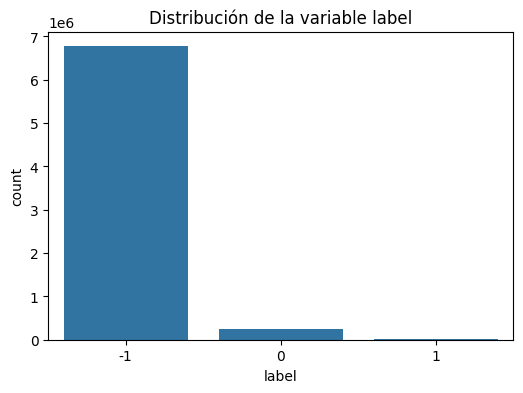

In [11]:
# Distribución de la variable label
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=dataTrain)
plt.title('Distribución de la variable label')
plt.show()


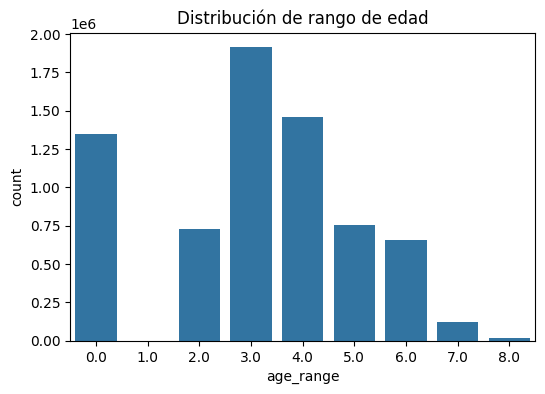

In [12]:
# Distribución de la edad
plt.figure(figsize=(6,4))
sns.countplot(x='age_range', data=dataTrain)
plt.title('Distribución de rango de edad')
plt.show()


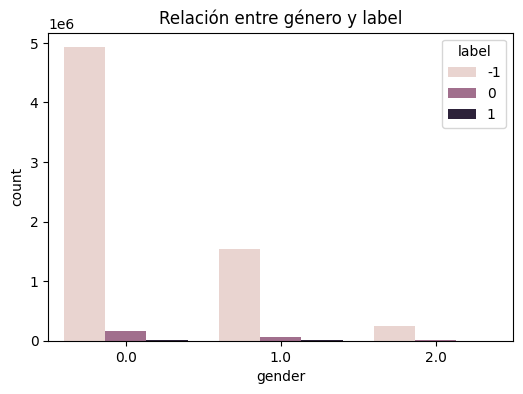

In [13]:
# Relación entre género y label
plt.figure(figsize=(6,4))
sns.countplot(x='gender', hue='label', data=dataTrain)
plt.title('Relación entre género y label')
plt.show()


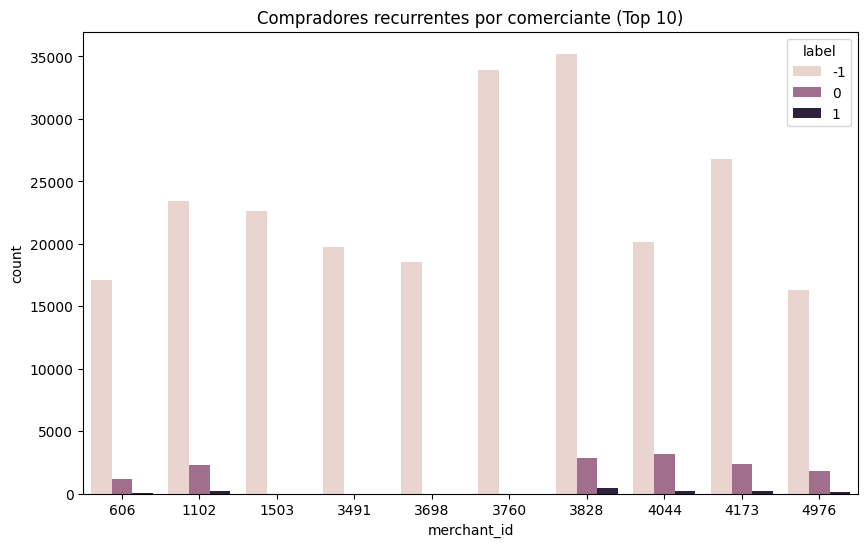

In [14]:
# Ver la cantidad de compradores recurrentes por comerciante
plt.figure(figsize=(10,6))
top_merchants = dataTrain['merchant_id'].value_counts().nlargest(10).index
sns.countplot(x='merchant_id', hue='label', data=dataTrain[dataTrain['merchant_id'].isin(top_merchants)])
plt.title('Compradores recurrentes por comerciante (Top 10)')
plt.show()


In [ ]:
# Visualizar las actividades de un usuario específico
user_sample = dataTrain[dataTrain['user_id'] == 34176]  # Reemplaza con un user_id de interés

# Muestra las actividades de este usuario a lo largo del tiempo (si hay timestamps en activity_log)
plt.figure(figsize=(10,6))
plt.plot(user_sample.index, user_sample['activity_count'], marker='o', linestyle='--')
plt.title(f'Actividad del usuario {34176} a lo largo del tiempo')
plt.xlabel('Registro')
plt.ylabel('Cantidad de Actividades')
plt.show()
